Welcome to the Stroke Prediction Project. Here, I delve into a fascinating journey of data exploration with the aim of identifying those at a higher risk of experiencing a stroke. The process is akin to a detective's work: thorough, precise, and driven by the desire to uncover hidden truths.

The journey starts with Exploratory Data Analysis, a deep dive into the dataset to find patterns and correlations. Next, I cleanse and standardize the data, preparing it for effective utilization in machine learning models.

Through visualizations, I then transform raw numbers into illustrative graphics, shedding light on trends within the data. The final step involves building machine learning models, trained to recognize patterns and make predictions about stroke risks.

The goal is simple yet crucial: to determine key factors contributing to stroke risk and provide actionable insights. This project draws from the promising field of medical computing, considering various health factors to refine the models and improve stroke predictions.

By improving stroke prediction, this project holds the potential to make a substantial positive impact on public health.

In [1]:
# Configuration
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore')

# Additional imports
from joblib import Parallel, delayed


# Standard library
from collections import Counter

# Third party libraries for data handling and analysis
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.weightstats as smweight
import statsmodels.stats.proportion as smprop
from scipy.stats import chisquare

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning libraries
import xgboost as xg
import shap
from catboost import Pool, CatBoostClassifier, cv
from sklearn import metrics
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
)
from sklearn.model_selection import cross_val_predict
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    GridSearchCV,
    KFold,
    StratifiedKFold,
    RandomizedSearchCV,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import parallel_backend
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# Local modules
from functions import *

# Miscellaneous
import pickle

# Visualization settings
palette = {"Yes": "red", "No": "green"}

In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col=0)
data.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.rename(columns={"Residence_type": "residence_type"}, inplace=True)


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [5]:
missing_values_count = data.isnull().sum()
missing_values_count


gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
duplicated_count = len(data[data.duplicated()])
duplicated_count


0

In [7]:
data.describe()


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Dataset Information

This dataset is comprised of 11 columns, with 10 being independent features and one representing the outcome variable. There are a total of 5110 rows, but some missing values are only present in the `bmi` column (201 to be exact). However, there are no duplicate entries in the data.

Of the 10 independent features, eight are categorical: `gender`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `residence_type`, `smoking_status`, and `stroke`. On the other hand, the remaining two features, `age` and `avg_glucose_level`, are numerical.

Although it may seem like `hypertension` and `heart_disease` are numeric, upon closer inspection, they are actually categorical since they indicate whether the patient suffers from these conditions or not (0 for no, 1 for yes).

The dataset contains the following attributes:

1. `id`: A unique identifier.
2. `gender`: Indicates the gender of the patient (`Male`, `Female`, or `Other`).
3. `age`: The age of the patient.
4. `hypertension`: Indicates whether the patient has hypertension or not (0 for `No`, 1 for `Yes`).
5. `heart_disease`: Indicates whether the patient has any heart diseases or not (0 for `No`, 1 for `Yes`).
6. `ever_married`: Indicates whether the patient is married or not (`No` or `Yes`).
7. `work_type`: Describes the employment status of the patient (`children`, `Govt_job`, `Never_worked`, `Private`, or `Self-employed`).
8. `residence_type`: Indicates the type of residence of the patient (`Rural` or `Urban`).
9. `avg_glucose_level`: The average glucose level in the patient`s blood.
10. `bmi`: Body mass index.
11. `smoking_status`: Describes the patient's smoking status (`formerly smoked`, `never smoked`, `smokes`, or `Unknown`).
12. `stroke`: Indicates whether the patient had a stroke or not (0 for `No`, 1 for `Yes`).

(*Note: The value `Unknown` in `smoking_status` means that information is unavailable for the patient.)

In [8]:
counts = data.groupby("stroke").size()
counts

stroke
0    4861
1     249
dtype: int64

In [9]:
replace_values = {1: "Yes", 0: "No"}
data["hypertension"] = data["hypertension"].map(replace_values)
data["heart_disease"] = data["heart_disease"].map(replace_values)
data_numerical = data.select_dtypes(include=("int64", "float64"))
data_categorical = data.select_dtypes(include="object")


*Analysis of numerical features*

In [10]:
data_numerical.dropna(inplace=True)
data_numerical.head()


,age,avg_glucose_level,bmi,stroke
id,,,,
9046,67.0,228.69,36.6,1
31112,80.0,105.92,32.5,1
60182,49.0,171.23,34.4,1
1665,79.0,174.12,24.0,1
56669,81.0,186.21,29.0,1


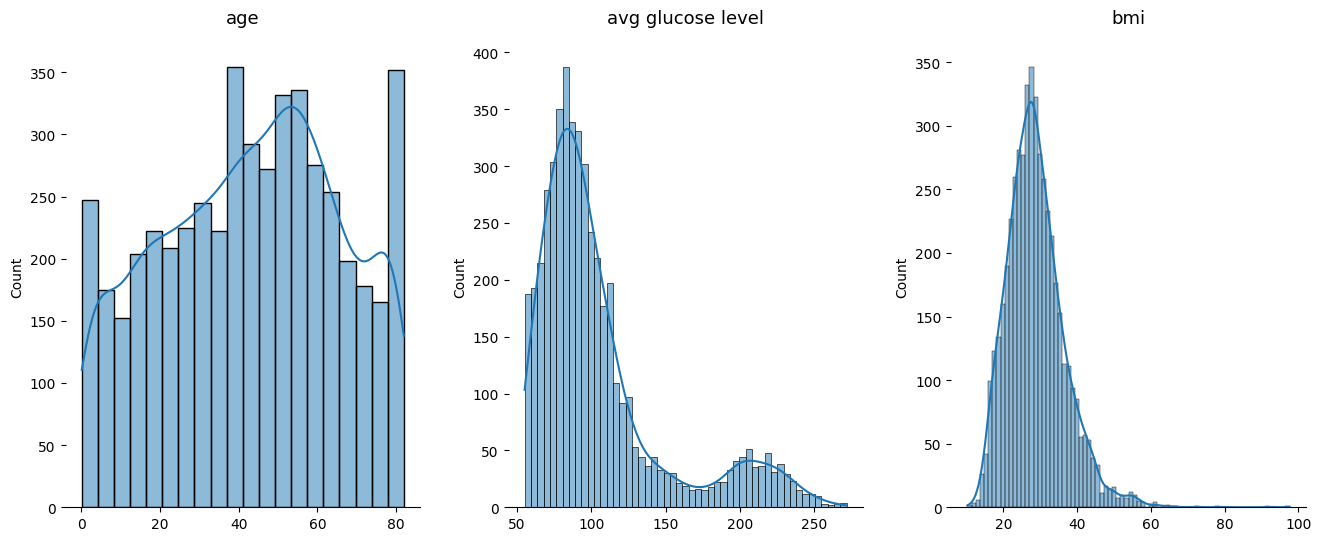

In [11]:
create_histplot(data_numerical, data_numerical.columns)


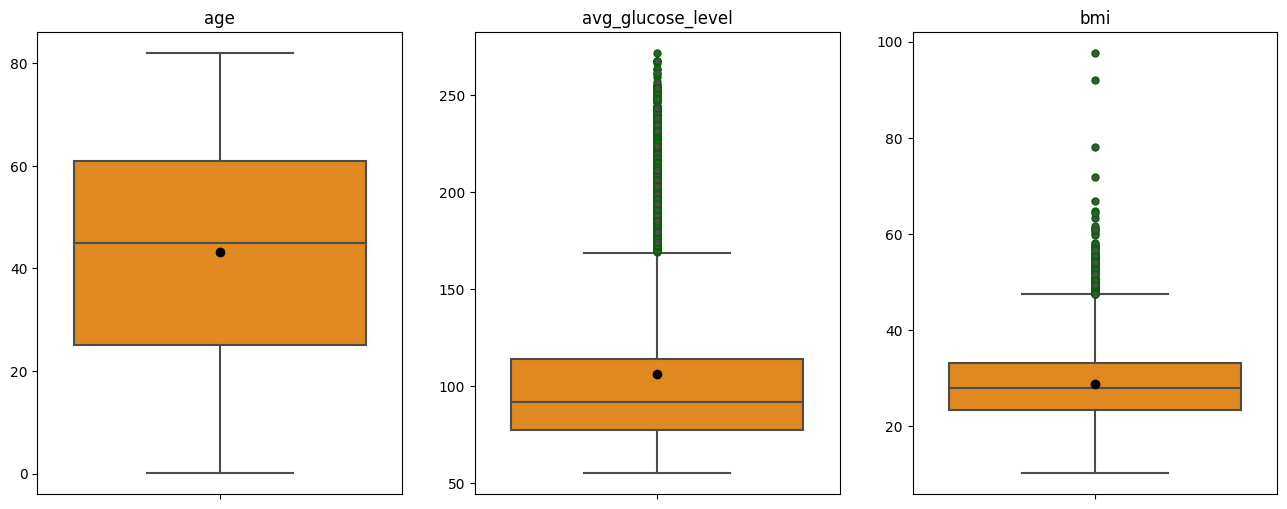

In [12]:
create_boxplot(data, data_numerical.columns)


**AGE**

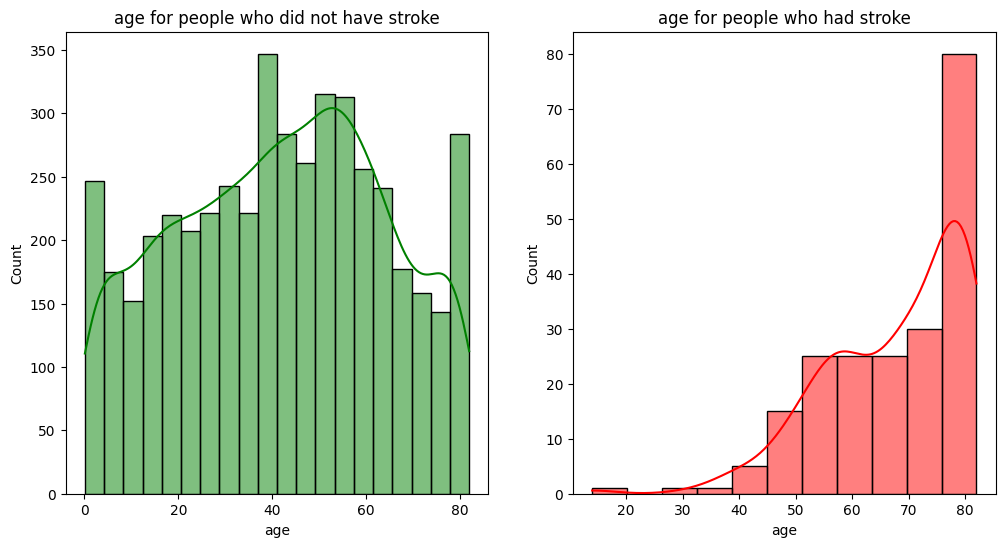

In [96]:
show_distribution(data, "stroke", "age")

Age is a significant factor in the risk of having a stroke. In general, as people age, the chances of experiencing a stroke increase. The data also shows that the patients who had a stroke tended to be older than those who did not. In fact, the risk of stroke doubles every decade after the age of 55. Therefore, it is important to take preventative measures and manage any underlying health conditions to reduce the risk of stroke, especially in older age groups.

### Average Glucose Level

To gain a clearer understanding of the possible indications of numbers in column 'avg_glucose_level', I have researched and compared the established norms of glucose levels for both healthy individuals and diabetic patients. According to the data retrieved from the website of Centers for Disease Control and Prevention aka "[CDC](https://www.cdc.gov/diabetes/basics/getting-tested.html)", patients with glucose levels below 100 mg/dL are determined to be healthy, while those with glucose levels between 100-125mg/dL are considered at risk. Patients with glucose values measured above 126 mg/dL are diagnosed as diabetic. It is worth mentioning that different types of glucose tolerance tests can yield varying results indicative of patient illness, although no information was given on which specific test(s) were used for dataset inclusion.

Judging by the boxplot, there are numerous outliers noticeable, with the highest recorded value being 271.74 mg/dL. Although high, this amount of glucose can still occur within a human body, therefore it cannot be classified as an actual outlier. Instead, this result must be considered as a possible test outcome. Since fasting blood sugar tests are primarily used for screening purposes, while glucose tolerance tests are more specialized, it is assumed that the dataset provides information solely on the former test type.

*I am taking a look if data distribution of avg_glucose_level and bmi differs while taking into account if the patient had a stroke or not.*

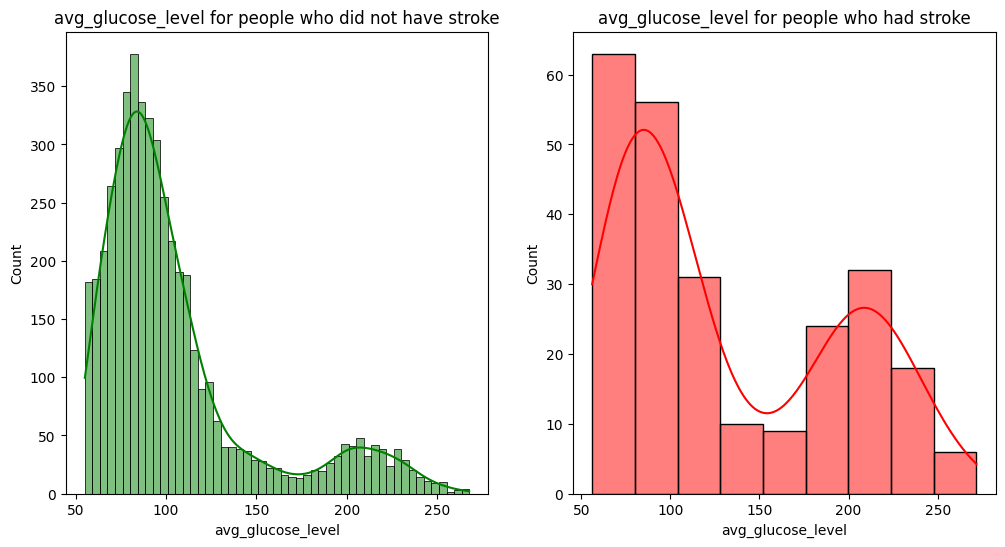

In [14]:
replace_values = {1: "Yes", 0: "No"}
data = data.replace({"stroke": replace_values})
show_distribution(data, "stroke", "avg_glucose_level")


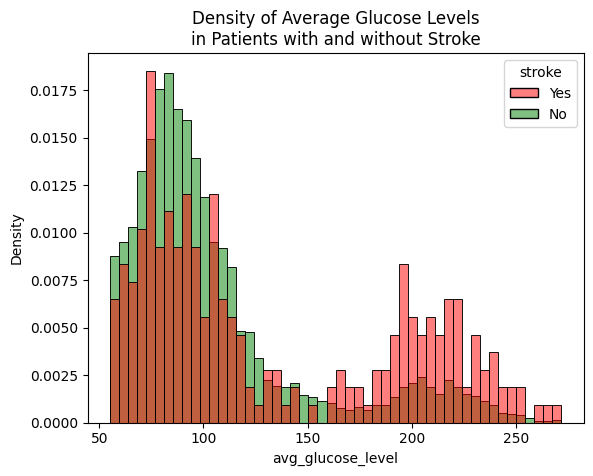

In [15]:
ax = sns.histplot(
    data=data,
    x="avg_glucose_level",
    hue="stroke",
    bins=50,
    stat="density",
    common_norm=False,
    palette=palette,
)
ax.set(title="Density of Average Glucose Levels\nin Patients with and without Stroke")
plt.show()

After an analysis of the data, it was observed that the distribution of average glucose levels between stroke and non-stroke patients seemed almost identical. However, a closer inspection using histograms indicated that there were nuanced variations. The histogram of stroke patients displayed a higher concentration of density around the average glucose levels ranging from 180-230, whereas in non-stroke patients, higher density was observed at average glucose levels ranging from 70-100. 

This observation leads us to believe that this distinction could be a significant determining factor in predicting if a patient is likely to experience a stroke or not.

### BMI

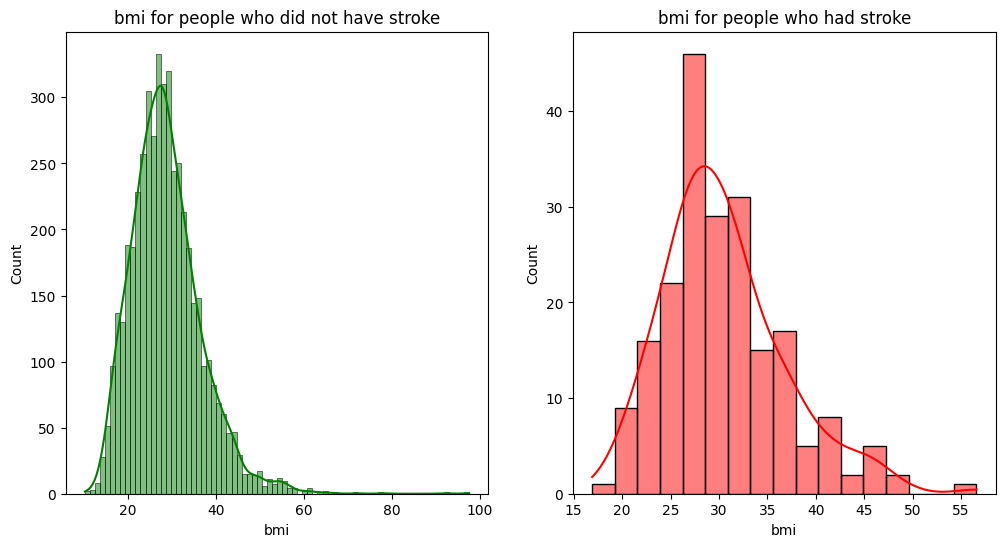

In [16]:
show_distribution(data, "stroke", "bmi")

In [17]:
len(data[data["bmi"] > 55])


33

In [18]:
data = data[data["bmi"] <= 55]


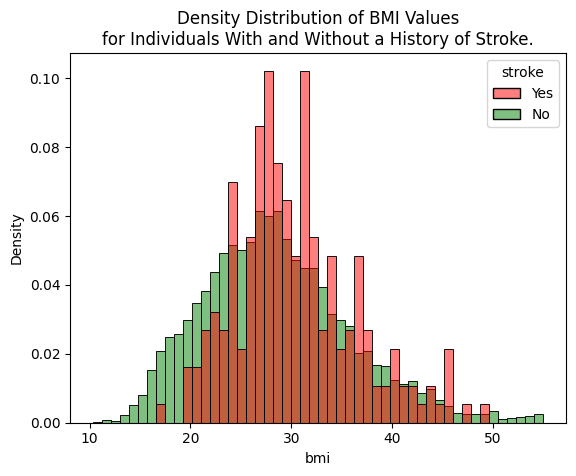

In [19]:
sns.histplot(
    data=data,
    x="bmi",
    hue="stroke",
    bins=50,
    stat="density",
    common_norm=False,
    palette=palette,
).set(
    title="Density Distribution of BMI Values\nfor Individuals With and Without a History of Stroke."
)
plt.show()

When I examined the histograms alone, it was not clear whether there were significant differences in their distributions. Therefore, I opted to conduct a Chi-squared test. While this test is typically used to assess differences in frequencies, I made modifications to use it to evaluate the similarity between two distributions. In the event that the two distributions were identical, I would see the same frequency of observations within each bin.

In [20]:
bmi_y, bmi_n = (
    data.loc[:, "bmi"][data.stroke == "Yes"].values,
    data.loc[:, "bmi"][data.stroke == "No"].values,
)

In [21]:
# Generate bins from group of patients without stroke
_, bins = pd.qcut(bmi_n, q=10, retbins=True)
bin_values = pd.cut(bmi_n, bins=bins).value_counts().index

# Use bins to compute frequencies for both groups
n_patients_nostroke, _ = np.histogram(bmi_n, bins=bins)
n_patients_stroke_actual, _ = np.histogram(bmi_y, bins=bins)

# Compute expected frequency in group of patients who had stroke
n_patients_total = n_patients_nostroke.sum()
n_patients_stroke_expected = (
    n_patients_nostroke / n_patients_total * n_patients_stroke_actual.sum()
)

# Create final DataFrame from binned data and computed frequencies
data_bins = pd.DataFrame(
    {
        "BMI_values": bin_values,
        "NR_of_patiens_without_stroke": n_patients_nostroke,
        "NR_of_patiens_with_stroke_actual": n_patients_stroke_actual,
        "NR_of_patiens_with_stroke_expected": n_patients_stroke_expected,
    }
)


data_bins


,BMI_values,NR_of_patiens_without_stroke,NR_of_patiens_with_stroke_actual,NR_of_patiens_with_stroke_expected
0,"(10.3, 19.5]",456,2,20.318766
1,"(19.5, 22.3]",471,12,20.987147
2,"(22.3, 24.4]",468,20,20.853470
3,"(24.4, 26.2]",450,13,20.051414
4,"(26.2, 27.9]",474,32,21.120823
5,"(27.9, 29.6]",465,24,20.719794
6,"(29.6, 31.8]",479,36,21.343616
7,"(31.8, 34.4]",469,22,20.898029
8,"(34.4, 38.6]",463,25,20.630677
9,"(38.6, 55.0]",473,22,21.076264


### Evaluating Hypothesis

We set forth to analyze the similarity between two distributions with the following hypotheses:

- Null Hypothesis (H_0): The two distributions are identical.

- Alternative Hypothesis (H_1): The two distributions are distinct.

To test these, we employ the chi-squared test:

In [22]:
stat, p_value = chisquare(
    data_bins["NR_of_patiens_with_stroke_actual"],
    data_bins["NR_of_patiens_with_stroke_expected"],
)
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")


Chi-squared Test: statistic=40.0902, p-value=0.0000


Upon analyzing the output, we see a significant Chi-Square statistic and a very low p-value. This statistical evidence leads us to reject the null hypothesis.

In more detailed terms, while the two distributions may have comparable central tendencies, their tails differ significantly. The Chi-Square test evaluates the entire distribution, not just the central portion, thus capturing this distinction.

**This result provides additional support for considering BMI as a potential factor in predicting strokes.**

### Categorical Features: An Analytical Overview

In [23]:
data_categorical.head()

,gender,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status
id,,,,,,,
9046,Male,No,Yes,Yes,Private,Urban,formerly smoked
51676,Female,No,No,Yes,Self-employed,Rural,never smoked
31112,Male,No,Yes,Yes,Private,Rural,never smoked
60182,Female,No,No,Yes,Private,Urban,smokes
1665,Female,Yes,No,Yes,Self-employed,Rural,never smoked


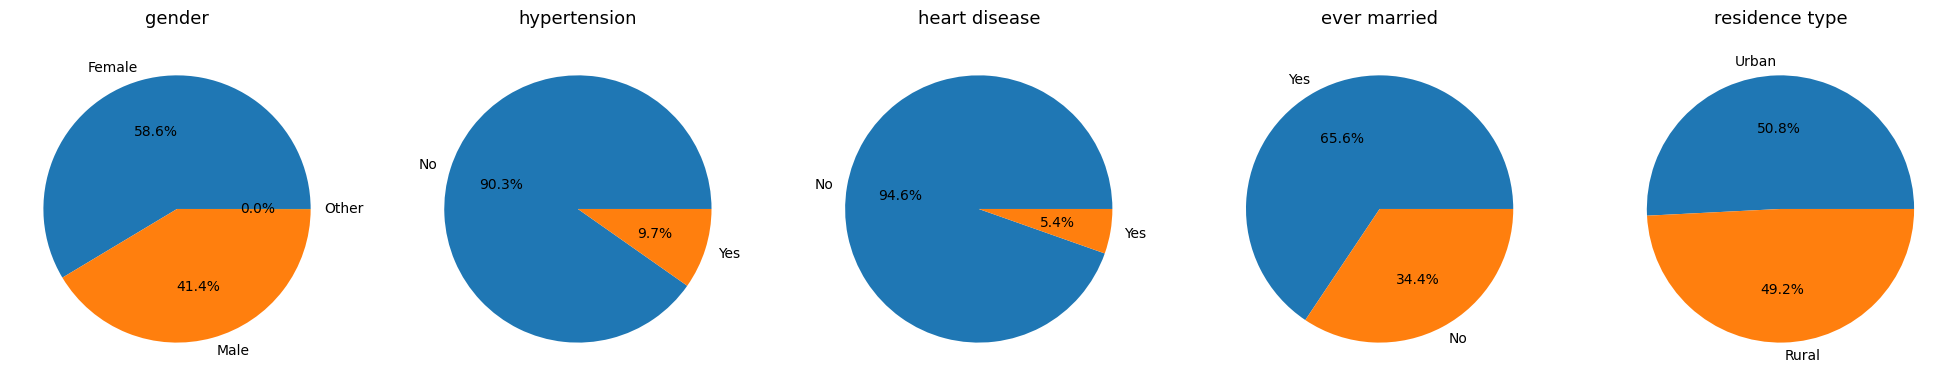

In [24]:
list_of_columns = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "residence_type",
]
create_pie_charts(data_categorical, list_of_columns)

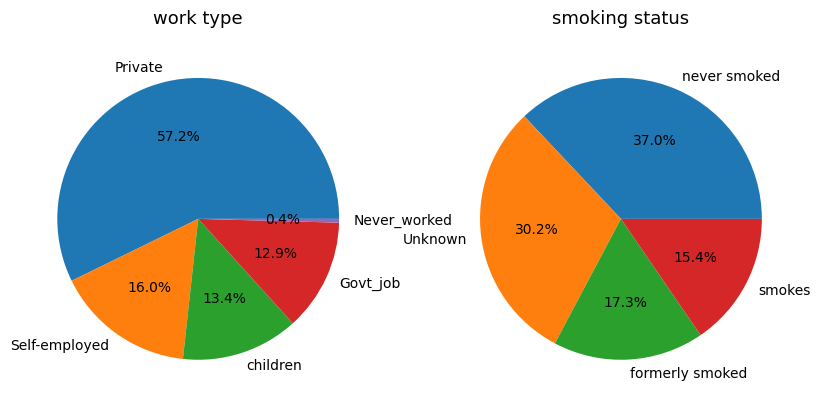

In [25]:
list_of_columns = ["work_type", "smoking_status"]
create_pie_charts(data_categorical, list_of_columns)


#### Insight

The provided information presents various observations from a particular aspect. 

1. The categorical features contain data about gender, which comprises males, females, and others. It is noteworthy that the majority of patients were female. 
2. It was observed that most patients did not suffer from hypertension or heart disease. 
3. Approximately two-thirds of patients were married. 
4. In terms of residence, the patients belonged to either an urban or rural area, with no apparent difference between the two. 
5. It was observed that most patients worked in the private sector
6. Most people have never smoked before, or there was no recorded information available about their smoking habits.

Furthermore, it is important to note the percentage of each group of people who suffered from a stroke versus those who did not.

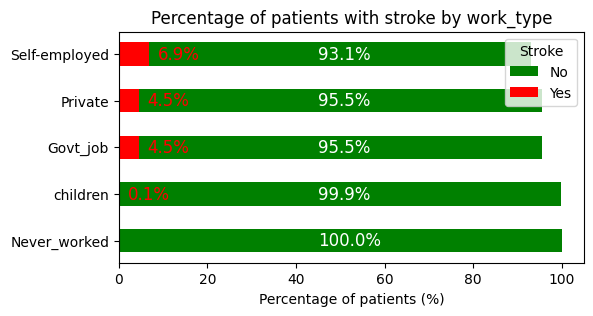

In [26]:
percentage_plot(data, "work_type")


#### Insights into Different Types of Work

After conducting the analysis, it can be concluded that being self-employed may have an impact on the likelihood of experiencing a stroke. However, the sample size of the self-employed group was three times smaller than that of people working in the private sector. This difference in sample sizes may potentially provide a misleading result or outcome. Therefore, further investigation and consideration of a larger and more diverse sample should be conducted to confirm the association between self-employment and stroke.

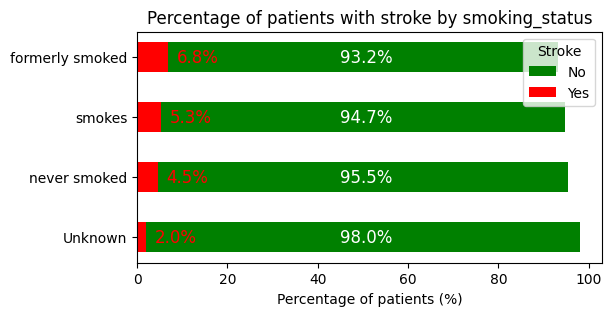

In [27]:
percentage_plot(data, "smoking_status")

#### Insights into Smoking Status

Having a history of smoking does not appear to have any effect on the likelihood of experiencing a stroke. Strange, huh?

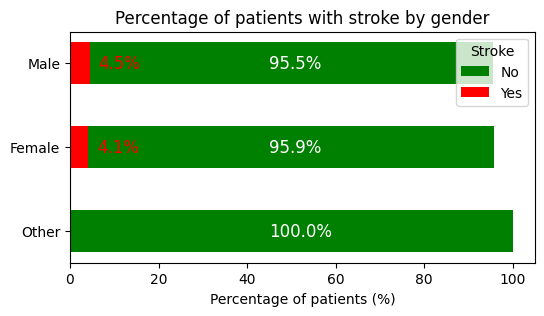

In [28]:
percentage_plot(data, "gender")


#### Insights into Gender 

Research suggests that gender does not appear to have a significant impact on an individual's likelihood of experiencing a stroke.

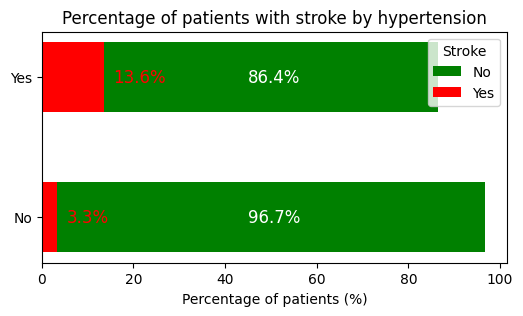

In [29]:
percentage_plot(data, "hypertension")

#### Insights into Hypertension

Yes, having hypertension (high blood pressure) is a major risk factor for stroke. High blood pressure can damage the blood vessels in the brain and make them more susceptible to blockages or ruptures, which can lead to a stroke. It is important to manage and control high blood pressure through lifestyle changes and medication to help reduce the risk of stroke and other health complications.

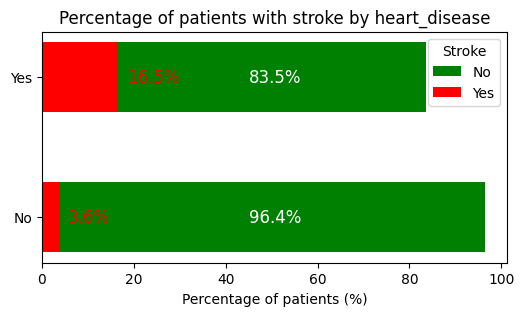

In [30]:
percentage_plot(data, "heart_disease")

#### Insights into Heart Disease

Yes, having heart disease is another major risk factor for stroke. Heart disease can lead to the buildup of plaque in the arteries, which can increase the risk of blood clots forming in the brain and causing a stroke. People with heart disease should work closely with their healthcare providers to manage their condition, including controlling high blood pressure, managing cholesterol levels, and making lifestyle changes like quitting smoking and eating a heart-healthy diet to help reduce their risk of stroke.

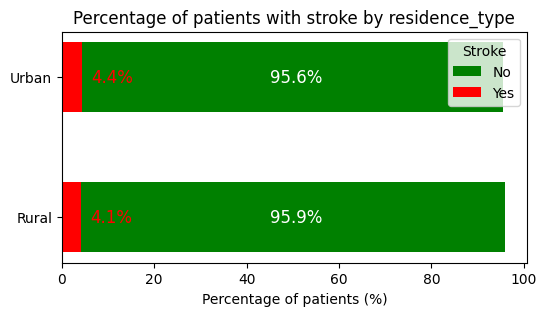

In [31]:
percentage_plot(data, "residence_type")


#### Insights into Residence Type 

Living in either a rural or urban area appears to have no discernible influence on the likelihood of experiencing a stroke.

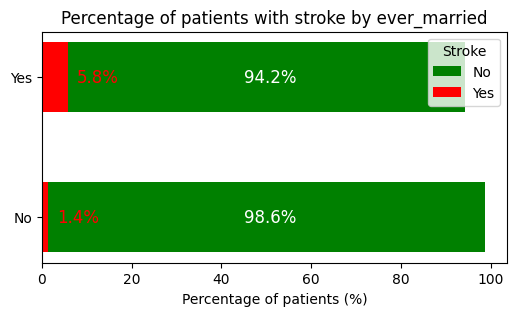

In [32]:
percentage_plot(data, "ever_married")


#### Insights into Maritial Status
 
The research suggests that one's marital status can significantly affect the likelihood of experiencing a stroke.

### General Insights

Our dataset records patients as young as under one year old, with the oldest being 82. The average age of individuals within the dataset is 42 years. Observing glucose levels, we notice a range from 50 to 275. This range indicates two prominent peaks: one around the value of 90, corresponding to normal glucose levels, and the other around 220, typically associated with diabetes. The average Body Mass Index (BMI) recorded is 28.9. The lowest BMI in the dataset is 10.3, while the highest is 97.6, a value that suggests a potential outlier given that BMI is generally expected to be under 40.

From the analysis of the data, age emerges as a significant factor in stroke risk. Additionally, elevated glucose levels may also hint at a greater likelihood of experiencing a stroke. The influence of BMI on stroke probability appears less pronounced.

Other variables that could play a substantial role in stroke risk include self-employment status, a history of hypertension or heart disease, and marital status. However, it's crucial to note that the dataset is significantly skewed. Out of 5110 individuals, only 249 have experienced a stroke, which may potentially bias our conclusions.

----

## Inference Through Statistics

Several attributes within our dataset appear to hold potential in predicting stroke risk. Specifically, I will delve into the potential influence of factors such as age, average glucose levels, marital status, and the presence of hypertension or heart disease on stroke outcomes.

In [33]:
stroke = data.loc[data["stroke"] == "Yes"].copy()
not_stroke = data.loc[data["stroke"] == "No"].copy()
replace_values_01 = {"Yes": 1, "No": 0}

stroke_not_stroke = [stroke, not_stroke]

for df in stroke_not_stroke:
    df.loc[:, ["hypertension", "heart_disease", "ever_married"]] = df.loc[
        :, ["hypertension", "heart_disease", "ever_married"]
    ].apply(lambda x: x.map(replace_values_01))


In [34]:
stroke[
    ["age", "avg_glucose_level", "hypertension", "heart_disease", "ever_married"]
].describe()


,age,avg_glucose_level,hypertension,heart_disease,ever_married
count,208.000000,208.000000,208.000000,208.000000,208.000000
mean,67.822115,134.140962,0.288462,0.192308,0.889423
std,12.331653,62.301263,0.454140,0.395064,0.314364
min,14.000000,56.110000,0.000000,0.000000,0.000000
25%,58.750000,80.355000,0.000000,0.000000,1.000000
50%,70.500000,106.250000,0.000000,0.000000,1.000000
75%,78.250000,196.762500,1.000000,0.000000,1.000000
max,82.000000,271.740000,1.000000,1.000000,1.000000


In [35]:
not_stroke[
    ["age", "avg_glucose_level", "hypertension", "heart_disease", "ever_married"]
].describe()


,age,avg_glucose_level,hypertension,heart_disease,ever_married
count,4668.000000,4668.000000,4668.000000,4668.000000,4668.00000
mean,41.757309,103.945726,0.081834,0.043488,0.64096
std,22.317771,42.909647,0.274141,0.203974,0.47977
min,0.080000,55.120000,0.000000,0.000000,0.00000
25%,24.000000,76.912500,0.000000,0.000000,0.00000
50%,43.000000,91.230000,0.000000,0.000000,1.00000
75%,59.000000,112.395000,0.000000,0.000000,1.00000
max,82.000000,267.760000,1.000000,1.000000,1.00000


- The level of significance for all tests is set at 5%.

- The statistical evaluation is performed using a two-sample t-test with unequal variances.

#### Age Hypothesis Test

- Hypothesis 1 (Null): There is no significant difference in the average age of individuals who have experienced a stroke and those who have not.

- Hypothesis 2 (Alternative): There exists a significant difference in the average ages of the two groups.

In [36]:
t_test = sm.stats.ttest_ind(stroke["age"], not_stroke["age"], usevar="unequal")
f"t-test: {t_test[0]}, p-value: {t_test[1]}, degrees of freedom: {t_test[2]}"

't-test: 28.476253538704952, p-value: 1.595391033873429e-83, degrees of freedom: 271.57412196358405'

Age Hypothesis Test Outcome: 

The p-value obtained is extremely small, almost zero. This leads us to reject the null hypothesis. Hence, we can infer that `there is a significant difference in the average age of those who have had a stroke and those who have not`.

#### Average Glucose Level Test

- Hypothesis 1 (Null): There is no difference in the average glucose levels between individuals who experienced a stroke and those who didn't.

- Hypothesis 2 (Alternative): There exists a significant difference in average glucose levels between these two groups.

In [37]:
t_test = sm.stats.ttest_ind(
    stroke["avg_glucose_level"], not_stroke["avg_glucose_level"], usevar="unequal"
)
f"t-test: {t_test[0]}, p-value: {t_test[1]}, degrees of freedom: {t_test[2]}"

't-test: 6.917213373536713, p-value: 5.150980928056149e-11, degrees of freedom: 215.83903233153964'

Average Glucose Level Test Outcome:

Based on our testing, we obtained a p-value approximating 0. This leads us to reject the null hypothesis. The test strongly suggests a `significant difference in average glucose levels between stroke and non-stroke patients`.

#### Hypertension Test

- Hypothesis 1 (Null): The proportion of individuals with hypertension does not influence the likelihood of experiencing a stroke.

- Hypothesis 2 (Alternative): Hypertension has a significant impact on the likelihood of experiencing a stroke.

In [38]:
t_test = sm.stats.ttest_ind(
    stroke["hypertension"], not_stroke["hypertension"], usevar="unequal"
)
f"t-test: {t_test[0]}, p-value: {t_test[1]}, degrees of freedom: {t_test[2]}"

't-test: 6.509284769893021, p-value: 5.292174652694787e-10, degrees of freedom: 213.77410204599786'

Hypertension Test Outcome:

The obtained p-value is very small, indicating a strong statistical basis to reject the null hypothesis. Our results suggest that `hypertension plays a significant role in stroke occurrence`.

#### Heart Disease Test

- Hypothesis 1 (Null): The presence of heart disease does not influence the probability of a stroke.

- Hypothesis 2 (Alternative): Heart disease significantly impacts the likelihood of a stroke.

In [39]:
t_test = sm.stats.ttest_ind(
    stroke["heart_disease"], not_stroke["heart_disease"], usevar="unequal"
)
f"t-test: {t_test[0]}, p-value: {t_test[1]}, degrees of freedom: {t_test[2]}"

't-test: 5.400841382681714, p-value: 1.7737422818836717e-07, degrees of freedom: 211.94539847192257'

Heart Disease Test Outcome:

With a very small p-value, we are confident in rejecting the null hypothesis. There is a `significant correlation between heart disease and the occurrence of strokes`.

#### Marital Status Test

- Hypothesis 1 (Null): Marital status has no bearing on the risk of having a stroke.

- Hypothesis 2 (Alternative): Being married significantly impacts the probability of having a stroke.

In [40]:
t_test = sm.stats.ttest_ind(
    stroke["ever_married"], not_stroke["ever_married"], usevar="unequal"
)
f"t-test: {t_test[0]}, p-value: {t_test[1]}, degrees of freedom: {t_test[2]}"

't-test: 10.849728444129894, p-value: 9.324460094213899e-23, degrees of freedom: 252.07611288115564'

Outcome:

A very small p-value near 0 provides strong evidence against the null hypothesis. Consequently, we can conclude that `marital status, specifically being married, significantly impacts stroke occurrence`.

### Asessing Relationships Among Variables and Preparing Data for Modeling

To understand how our variables interact with each other, it's important to investigate their relationships. However, before we can do that, we need to ensure all our data is in a format that can be compared - that means changing any non-numeric data into a numeric form. This step is known as encoding.

Encoding is also a critical part of preparing our data for machine learning models. Different models have different requirements: for example, algorithms like Logistic Regression or Support Vector Machines need numerical inputs to function properly. On the other hand, a Decision Tree can handle non-encoded features.

Since we'll be testing a variety of models for our analysis, it's a good idea to take care of encoding now. By transforming all our variables into a comparable format, we're setting the stage for a smooth and efficient modeling process.

Transforming Categorical Variables: Converting Text into Numerical Values:

In [41]:
data_corr = data.copy()
data_corr = data_corr.replace(
    {
        "hypertension": replace_values_01,
        "heart_disease": replace_values_01,
        "ever_married": replace_values_01,
    }
)
column_trans = make_column_transformer(
    (
        OneHotEncoder(handle_unknown="ignore"),
        ["gender", "work_type", "residence_type", "smoking_status"],
    ),
    remainder="passthrough",
)

data_transformed = column_trans.fit_transform(data_corr)
data_transformed

array([[0.0, 1.0, 0.0, ..., 228.69, 36.6, 'Yes'],
       [0.0, 1.0, 0.0, ..., 105.92, 32.5, 'Yes'],
       [1.0, 0.0, 0.0, ..., 171.23, 34.4, 'Yes'],
       ...,
       [1.0, 0.0, 0.0, ..., 82.99, 30.6, 'No'],
       [0.0, 1.0, 0.0, ..., 166.29, 25.6, 'No'],
       [1.0, 0.0, 0.0, ..., 85.28, 26.2, 'No']], dtype=object)

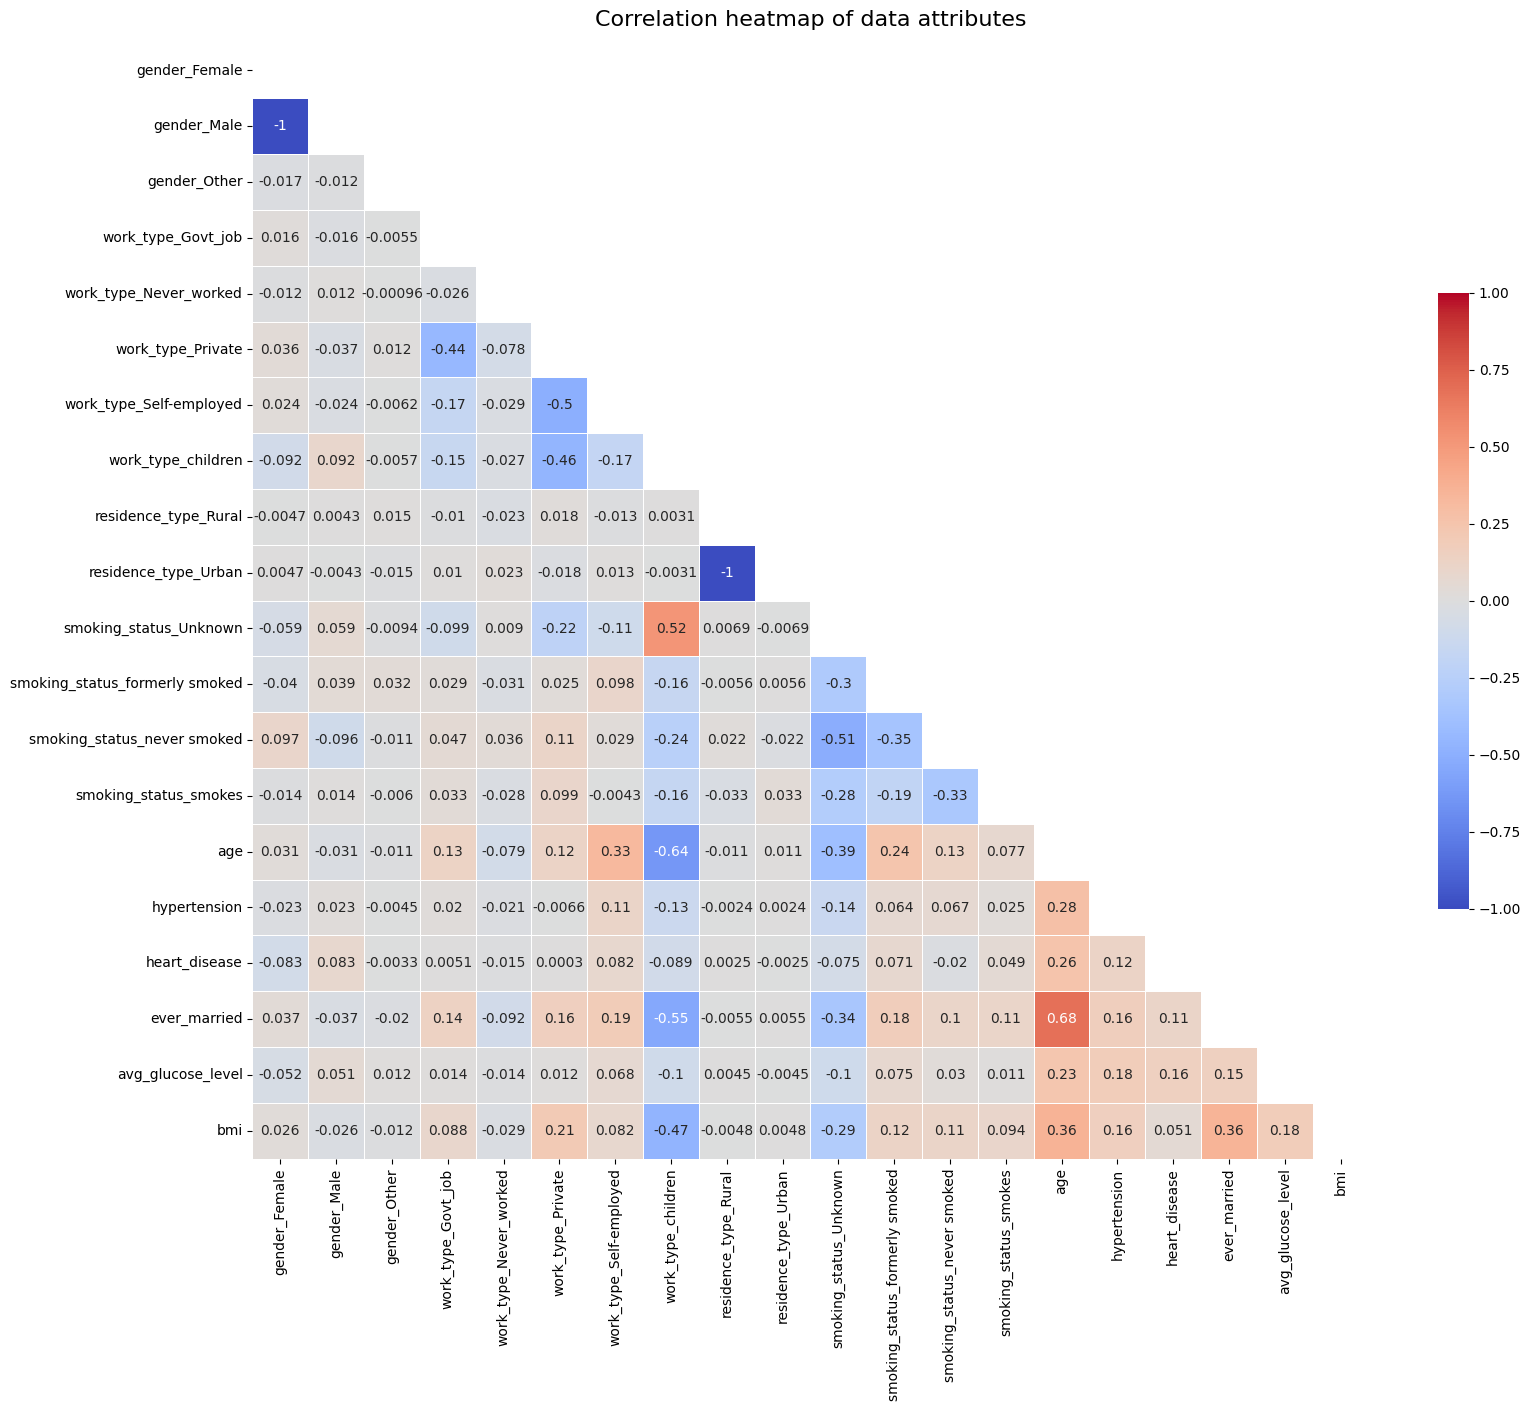

In [42]:
encoded_data = pd.DataFrame(
    data_transformed, columns=column_trans.get_feature_names_out()
)
correlation_data = encoded_data.iloc[:, 0:-1].astype(float)

correlation_data.columns = correlation_data.columns.str.replace(
    "onehotencoder__", ""
).str.replace("remainder__", "")
create_heatmap(correlation_data, (18, 16))

Conclusion: 

Based on the heatmap showcasing Pearson correlation coefficients, it's clear that there's no strong relationship (either positive or negative) between the variables in our dataset. In simple terms, this means that changes in one feature don't necessarily correspond to predictable changes in another, at least not to a significant degree. It's an important observation as it helps guide our next steps in the data analysis and model building process.

### Forecasting with Machine Learning Models

In this section, we'll dive into the heart of our investigation, the development and refinement of predictive models. Leveraging machine learning, we'll construct algorithms to make educated guesses about future outcomes based on the patterns found in our dataset. 

Our goal here is to create a model that can accurately identify those at risk of stroke, offering potential for early interventions and improved health outcomes.

In [43]:
data = data.dropna(axis=0)

In [44]:
numeric_features = ["age", "avg_glucose_level", "bmi"]
categorical_features = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X = data.iloc[:, :-1]
y = data.iloc[:, -1].replace({"Yes": 1, "No": 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

### Evaluating Multiple Models Through Streamlined Workflows

This "pipeline testing" phase is an essential part of our project where we systematically assess various models to identify the most promising one. We aim to ensure the model we ultimately deploy is the best suited for accurately predicting the likelihood of a stroke.

In [45]:
pipelines = []
pipelines.append(
    (
        "Logistic Regression",
        (
            Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("LR", LogisticRegression(class_weight="balanced")),
                ]
            )
        ),
    )
)
pipelines.append(
    (
        "kNN",
        (
            Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("KNN", KNeighborsClassifier(n_neighbors=5)),
                ]
            )
        ),
    )
)
pipelines.append(
    (
        "Decision Tree",
        (
            Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("DT", DecisionTreeClassifier(class_weight="balanced")),
                ]
            )
        ),
    )
)
pipelines.append(
    (
        "Random Forest",
        (
            Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("RF", RandomForestClassifier(class_weight="balanced")),
                ]
            )
        ),
    )
)
pipelines.append(
    (
        "SVC linear",
        (
            Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("SVC", SVC(kernel="linear", class_weight="balanced")),
                ]
            )
        ),
    )
)
pipelines.append(
    (
        "SVC rbf",
        (
            Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("SVC", SVC(kernel="rbf", class_weight="balanced")),
                ]
            )
        ),
    )
)


In [46]:
model_name, roc_auc, model_comparison = calculate_roc_auc(
    pipelines, X_train, y_train)
model_comparison


,CV mean,Std
Logistic Regression,0.828178,0.044236
kNN,0.619931,0.022593
Decision Tree,0.531735,0.022069
Random Forest,0.800565,0.035856
SVC linear,0.825109,0.043517
SVC rbf,0.776404,0.030701


The table above represents the cross-validation results for different machine learning models.

`CV mean`: This is the mean score of the model's performance during cross-validation. A higher value of `CV mean` indicates better model performance.

`Std`: This represents the standard deviation of the model's performance during cross-validation. A lower value of `Std` indicates that the model's performance was consistent across all folds of cross-validation.

Looking at the table, we can see that the Logistic Regression model has the highest CV mean score of 0.828 and the second lowest Std score of 0.044. This indicates that the Logistic Regression model performed well in terms of accuracy and consistency during cross-validation.

On the other hand, kNN model has a CV mean of 0.5 which means the model is not performing better than the random guessing. Furthermore, it has 0 Std which means its performance does not change across the different folds of the cross-validation.

In [47]:
box = pd.DataFrame(roc_auc, index=[model_name])
box.T

,Logistic Regression,kNN,Decision Tree,Random Forest,SVC linear,SVC rbf
0,0.778081,0.620393,0.556161,0.737132,0.779826,0.726772
1,0.797813,0.615234,0.556146,0.824246,0.796154,0.779487
2,0.893651,0.584854,0.526653,0.833333,0.889638,0.821032
3,0.866923,0.655817,0.521250,0.823365,0.864375,0.788462
4,0.804420,0.623359,0.498464,0.784748,0.795550,0.766265


ROC AUC is a performance metric used to evaluate the accuracy of classification models. It measures how well the model can distinguish between positive and negative classes by plotting the true positive rate (TPR) against the false positive rate (FPR) at different threshold values.

The ROC AUC score ranges between 0 and 1, with a score of 0.5 indicating that the model performs no better than random guessing, and a score of 1 indicating perfect performance.

In the context of the result table above, different classification models (Logistic Regression, kNN, Decision Tree, Random Forest, SVM with linear kernel, and SVM with RBF kernel) were trained and tested on a dataset, and the performance of each model was evaluated using the ROC AUC metric across multiple experiments. The result table shows the ROC AUC scores achieved by each model in each experiment. By looking at the values in the table, we can compare the relative performance of different models across different experiments.

For example, we can see that Logistic Regression consistently achieves a relatively high ROC AUC score across all experiments, indicating that it performs well in distinguishing between positive and negative classes. On the other hand, kNN consistently achieves a low ROC AUC score, indicating that it has poor performance compared to the other models.

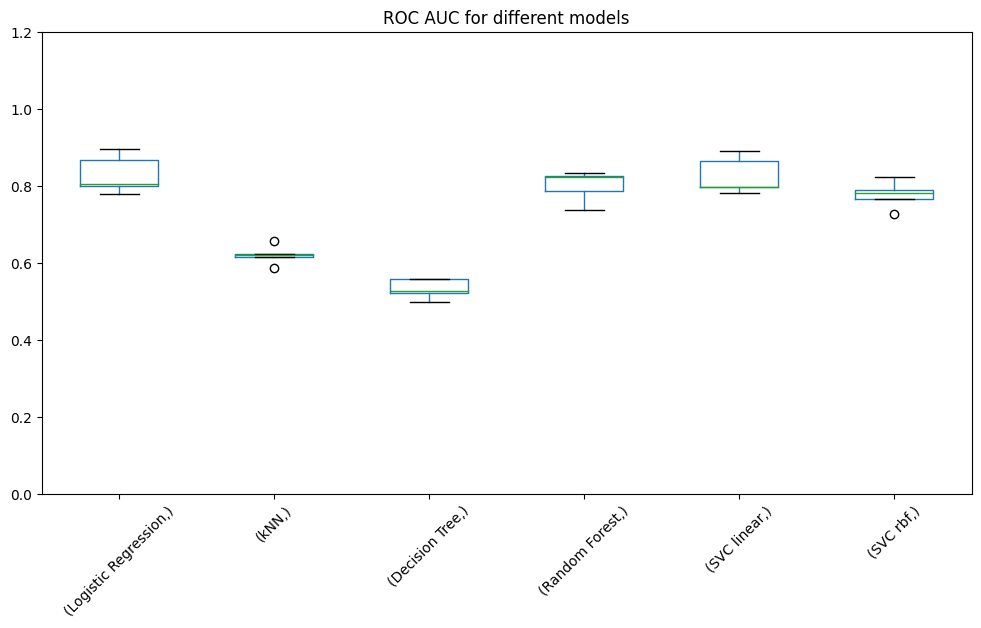

In [48]:
plt.subplots(figsize=(12, 6))
box.T.boxplot(grid=False, rot=45)
ax = plt.gca()
ax.set_ylim([0, 1.2])
plt.title("ROC AUC for different models")
plt.show()


Using boxplots above to visualize these results can help us better understand the distribution of ROC AUC scores for each model across all experiments. 

The boxplot shows the median ROC AUC score (represented by the horizontal line inside the box), the interquartile range (IQR) of the scores (represented by the height of the box), and the range of the scores (represented by the whiskers extending from the top and bottom of the box).

The circles in a boxplot represent the outliers of a dataset, which are data points that fall outside of the range of most of the other data points. In a boxplot, outliers are defined as values that are more than 1.5 times the interquartile range (IQR) above the upper quartile or below the lower quartile.

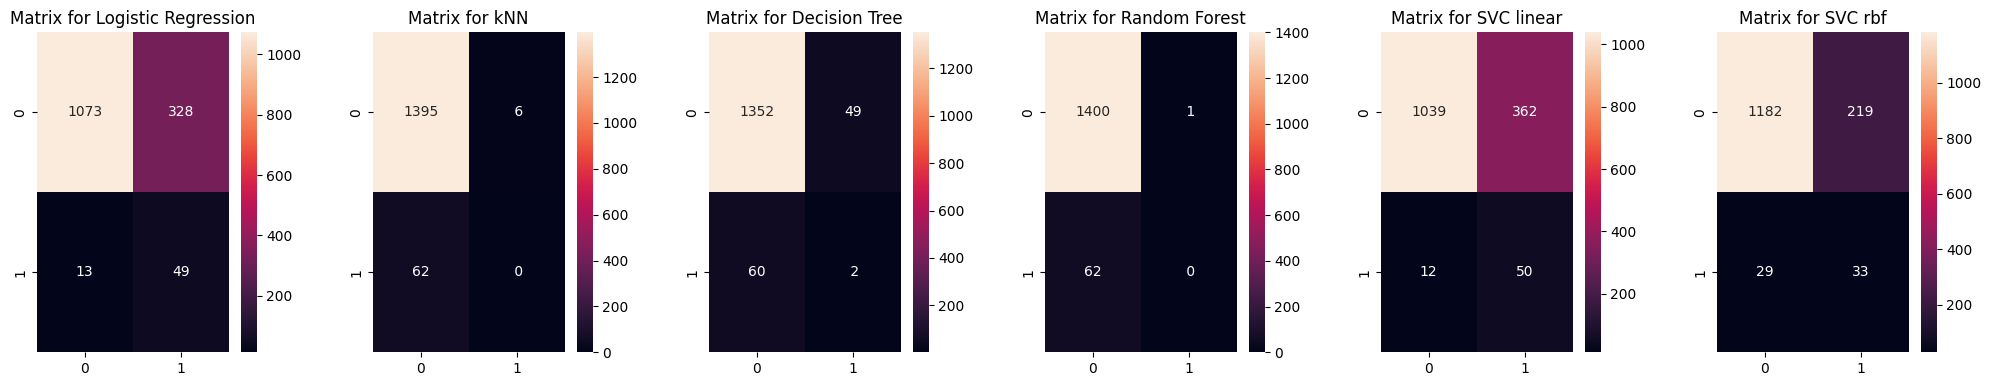

In [49]:
dict_of_models = {model_name: model for model_name, model in pipelines}
create_confusion_matrix(dict_of_models, X_test, y_test)

In [50]:
report_data = []

for i in ["Logistic Regression", "SVC linear", "SVC rbf"]:
    dict_of_models[i].fit(X_train, y_train)
    y_pred = dict_of_models[i].predict(X_test)
    report_data.append((i, classification_report(y_test, y_pred, output_dict=True)))

for model_name, model_dict in report_data:
    print("\n", model_name)
    print(pd.DataFrame(model_dict).T)


 Logistic Regression
              precision    recall  f1-score     support
0              0.991194  0.723055  0.836154  1401.00000
1              0.120181  0.854839  0.210736    62.00000
accuracy       0.728640  0.728640  0.728640     0.72864
macro avg      0.555688  0.788947  0.523445  1463.00000
weighted avg   0.954281  0.728640  0.809649  1463.00000

 SVC linear
              precision    recall  f1-score      support
0              0.992016  0.709493  0.827299  1401.000000
1              0.117137  0.870968  0.206501    62.000000
accuracy       0.716336  0.716336  0.716336     0.716336
macro avg      0.554576  0.790230  0.516900  1463.000000
weighted avg   0.954940  0.716336  0.800991  1463.000000

 SVC rbf
              precision    recall  f1-score      support
0              0.984215  0.756602  0.855529  1401.000000
1              0.116580  0.725806  0.200893    62.000000
accuracy       0.755297  0.755297  0.755297     0.755297
macro avg      0.550398  0.741204  0.528211  1463

These results represent the performance of three different machine learning models - Logistic Regression, SVC linear, and SVC rbf. Each of these models has been used to make predictions, and their precision, recall, f1-score, and support values are given above. The term `support` refers to the number of actual occurrences of the class in the specified dataset.

In simple terms:

- `Precision` tells us about the accuracy of positive predictions. High precision means that the model predicts the positive class (1) accurately and gives fewer false positives.
- `Recall` (also known as sensitivity or true positive rate) measures the proportion of actual positives that are correctly identified. High recall means the model correctly identified more of the positive class (1).
- The `F1 score` is the harmonic mean of precision and recall. A higher F1 score means the model is more robust, and balances precision and recall.
- The `accuracy` is the ratio of correct predictions to total predictions. It's a good measure when the classes are balanced. A higher accuracy means the model predicted more instances correctly.
- `Macro average` computes the metric independently for each class and then takes the average, treating all classes equally.
- `Weighted average` computes the metric for each class independently but when it adds them together, it uses a weight that depends on the number of true instances for each class.

Comparing the models:

- `SVC rbf` has the highest accuracy (~75.5%), meaning it made the most correct predictions out of all instances. It has the best performance in identifying the negative class (0) as shown by the precision of 98.4%.
- However, `SVC linear` model has the best recall for the positive class (1), which means it correctly identified ~87.1% of positive instances.
- All models have similar F1 scores for class 0 but a significantly low F1 score for class 1, suggesting they have difficulties balancing precision and recall for the positive class. This is likely due to an imbalance in the dataset, with significantly more negative instances than positive ones. 

### Observation

After first checking our models, we found that `Decision Trees` and `Random Forest` models seemed pretty accurate. But when we dug a bit deeper, we noticed a problem: these models had a hard time making correct predictions in the "positive" category. For example, the `Random Forest` model didn't make a single correct prediction in this category.

On the flip side, we saw that models based on `Linear Regression` and `Support Vector Machines`, even though they were less accurate overall, did manage to make some right calls in the positive category.

Our main goal moving forward is to get better at correctly identifying the positive class and at the same time, cut down on the number of false negatives.

We have to be careful here, because there's a fine line to walk. On one hand, more testing means higher costs, but it could also mean fewer deaths. On the other hand, if more people die, that's not only tragic, but it also raises serious ethical issues. We need to find a balance between these two factors as we continue fine-tuning our models.

I'm going to make an attempt at adjusting the threshold for our predictions. This essentially means I'll tweak the cut-off point that helps us decide when to classify something as a positive case. By doing this, we might be able to change the outcomes and improve the performance of our models. The goal is to find a threshold that strikes the right balance, improving the recall of our positive class, reducing false negatives, and potentially making our model more precise and reliable. This is a common technique in data science, especially when dealing with imbalanced classes, and it can have a big impact on how well our model performs.

In [51]:
clf = dict_of_models["Logistic Regression"]
pred_proba_df = pd.DataFrame(clf.predict_proba(X_test))
threshold_list = [
    0.4,
    0.45,
    0.5,
    0.55,
    0.6,
    0.65,
    0.7,
    0.75,
    0.8,
]
for i in threshold_list:
    print("Threshold: {}".format(i))
    y_pred = pred_proba_df.applymap(lambda x: 1 if x > i else 0)
    test_accuracy = metrics.accuracy_score(
        y_test.to_numpy().reshape(y_test.to_numpy().size, 1),
        y_pred.iloc[:, 1].to_numpy().reshape(y_pred.iloc[:, 1].to_numpy().size, 1),
    )
    print("Testing accuracy : {}".format(test_accuracy))

    print(
        confusion_matrix(
            y_test.to_numpy().reshape(y_test.to_numpy().size, 1),
            y_pred.iloc[:, 1].to_numpy().reshape(y_pred.iloc[:, 1].to_numpy().size, 1),
        )
    )
    print()

Threshold: 0.4
Testing accuracy : 0.6596035543403964
[[909 492]
 [  6  56]]

Threshold: 0.45
Testing accuracy : 0.6924128503075871
[[958 443]
 [  7  55]]

Threshold: 0.5
Testing accuracy : 0.7286397812713602
[[1013  388]
 [   9   53]]

Threshold: 0.55
Testing accuracy : 0.7593984962406015
[[1058  343]
 [   9   53]]

Threshold: 0.6
Testing accuracy : 0.7887901572112098
[[1103  298]
 [  11   51]]

Threshold: 0.65
Testing accuracy : 0.8120300751879699
[[1139  262]
 [  13   49]]

Threshold: 0.7
Testing accuracy : 0.8386876281613124
[[1183  218]
 [  18   44]]

Threshold: 0.75
Testing accuracy : 0.8653451811346549
[[1231  170]
 [  27   35]]

Threshold: 0.8
Testing accuracy : 0.8926862611073137
[[1280  121]
 [  36   26]]



For each threshold value specified in `threshold_list`, I calculated the predicted classes based on that threshold and then computed evaluation metrics such as accuracy and confusion matrix. 

As we can see from the results, increasing the threshold value generally leads to lower sensitivity (more false negatives) but higher specificity (less false positives). This tradeoff is reflected in the changes in the confusion matrix values as well as the testing accuracy metric.

For example, when threshold value was 0.5, we had an accuracy of 0.7286 and the confusion matrix indicates that we had 388 false positives and 9 false negatives. When the threshold value was increased, the accuracy improved, but at the cost of more false negatives and fewer false positives. 


The results we've gotten so far are not quite where we want them to be. Our next step is to experiment with a technique called upsampling and downsampling. This is a common approach in data science when dealing with imbalanced datasets - it's a way to ensure that our models don't overlook the less prevalent, but often more important category, in this case, the positive class.

### Trying the Upsampling
Let's first look at upsampling, where we increase the number of positive class examples. This can give our models a better chance of spotting and learning from these crucial instances. We're essentially giving more weight to the positive class to improve its recognition in our models. So, let's see how applying upsampling to our positive class impacts the results.

In [52]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)
X_train_res = preprocessor.fit_transform(X_train_res)
X_test_res = preprocessor.transform(X_test_res)
smote = SMOTE(random_state=1)
X_train_res, y_train_res = smote.fit_resample(X_train_res, y_train_res)
unique, counts = np.unique(y_train_res, return_counts=True)
dict(zip(unique, counts))
classifiers = [
    "Linear SVM",
    "Radial SVM",
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
]

models = [
    SVC(kernel="linear", class_weight="balanced"),
    SVC(kernel="rbf", class_weight="balanced"),
    LogisticRegression(class_weight="balanced"),
    DecisionTreeClassifier(class_weight="balanced"),
    RandomForestClassifier(class_weight="balanced"),
]

In [53]:
calculate_roc_auc_models(models, X_train_res, y_train_res, classifiers)

,CV mean,Std
Random Forest,0.997120,0.003762
Radial SVM,0.967906,0.005330
Decision Tree,0.930829,0.016673
Logistic Regression,0.851643,0.008627
Linear SVM,0.851327,0.009644


The table above shows the cross-validation (CV) mean and standard deviation (Std) of five different models: Random Forest, Radial SVM, Decision Tree, Logistic Regression, and Linear SVM. CV mean is a measure of the average performance of the model across five folds of data during cross-validation, where higher values indicate better performance. The standard deviation provides a measure of the variability of the results across the different folds of data. Models with higher CV means and lower standard deviation generally tend to be preferred over models with lower CV means and higher standard deviations.

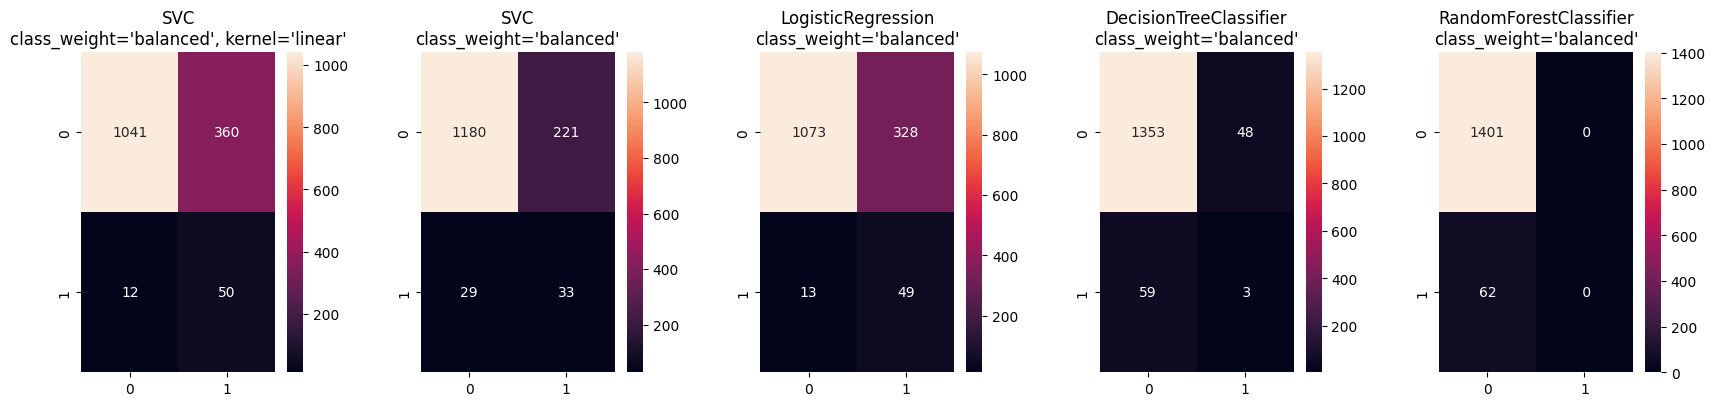

In [54]:
create_confusion_matrix_for_list(models, X_test_res, y_test_res)

In [55]:
list_of_models = ["Logistic Regression", "SVC linear", "SVC rbf"]

for model_name, model in zip(list_of_models, models):
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_res)
    print(f"\n {model_name}")
    print(pd.DataFrame(classification_report(y_test_res, y_pred, output_dict=True)).T)


 Logistic Regression
              precision    recall  f1-score      support
0              0.991054  0.711635  0.828417  1401.000000
1              0.115974  0.854839  0.204239    62.000000
accuracy       0.717703  0.717703  0.717703     0.717703
macro avg      0.553514  0.783237  0.516328  1463.000000
weighted avg   0.953969  0.717703  0.801965  1463.000000

 SVC linear
              precision    recall  f1-score      support
0              0.973132  0.827266  0.894290  1401.000000
1              0.110294  0.483871  0.179641    62.000000
accuracy       0.812714  0.812714  0.812714     0.812714
macro avg      0.541713  0.655569  0.536965  1463.000000
weighted avg   0.936566  0.812714  0.864004  1463.000000

 SVC rbf
              precision    recall  f1-score      support
0              0.991228  0.725910  0.838072  1401.000000
1              0.121281  0.854839  0.212425    62.000000
accuracy       0.731374  0.731374  0.731374     0.731374
macro avg      0.556255  0.790374  0.525248

The process of upsampling the minority class, which involves generating synthetic samples for the underrepresented class, was found to be ineffective in improving the prediction performance of the classifier model. Despite the additional samples generated by upsampling, the model's ability to classify instances of the minority class did not improve significantly.

#### Trying the Random Undersampling

Downsampling involves reducing the number of samples in the majority class, which is the class with more instances in a given dataset. Random undersampling is a common technique for achieving this. It randomly eliminates instances from the majority class until the class distribution is balanced.

In [56]:
scoring = ["accuracy", "balanced_accuracy", "roc_auc"]
index = []
scores = {"Accuracy": [], "Balanced accuracy": [], "ROC_AUC": []}
sampling_strategies = []

lr_clf = make_pipeline(
    RandomUnderSampler(random_state=42),
    preprocessor,
    LogisticRegression(max_iter=1000),
)
index += ["Undersampling the Logistic regression"]
cv_result = cross_validate(lr_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["ROC_AUC"].append(cv_result["test_roc_auc"].mean())
sampling_strategies.append(("lr", lr_clf))
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy,ROC_AUC
Undersampling the Logistic regression,0.71316,0.732806,0.824148


In [57]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T


,precision,recall,f1-score,support
0,0.991812,0.691649,0.814971,1401.000000
1,0.111111,0.870968,0.197080,62.000000
accuracy,0.699248,0.699248,0.699248,0.699248
macro avg,0.551461,0.781308,0.506025,1463.000000
weighted avg,0.954489,0.699248,0.788785,1463.000000


In [58]:
rf_clf = make_pipeline(
    RandomUnderSampler(random_state=42),
    preprocessor,
    RandomForestClassifier(random_state=42, n_jobs=2),
)

index += ["Undersampling the Random Forest"]
cv_result = cross_validate(rf_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["ROC_AUC"].append(cv_result["test_roc_auc"].mean())
sampling_strategies.append(("rf", rf_clf))
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

df_scores = pd.DataFrame(scores, index=index)
df_scores


,Accuracy,Balanced accuracy,ROC_AUC
Undersampling the Logistic regression,0.713160,0.732806,0.824148
Undersampling the Random Forest,0.686496,0.708644,0.781339


In [59]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.988360,0.666667,0.796249,1401.000000
1,0.098456,0.822581,0.175862,62.000000
accuracy,0.673274,0.673274,0.673274,0.673274
macro avg,0.543408,0.744624,0.486056,1463.000000
weighted avg,0.950647,0.673274,0.769958,1463.000000


In [60]:

with parallel_backend('threading'):
    rf_clf_balanced = make_pipeline(
        preprocessor,
        BalancedRandomForestClassifier(random_state=42, n_jobs=2),
    )
# Evaluation


index += ["Balanced Random Forest"]
with parallel_backend('threading'):
    cv_result = cross_validate(rf_clf_balanced, X_train, y_train, scoring=scoring)

#cv_result = cross_validate(rf_clf_balanced, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())
scores["ROC_AUC"].append(cv_result["test_roc_auc"].mean())
sampling_strategies.append(("rf_clf_balanced", rf_clf_balanced))
#rf_clf_balanced.fit(X_train, y_train)
#y_pred = rf_clf_balanced.predict(X_test)

# Model fitting
with parallel_backend('threading'):
    rf_clf_balanced.fit(X_train, y_train)

# Prediction
with parallel_backend('threading'):
    y_pred = rf_clf_balanced.predict(X_test)


df_scores = pd.DataFrame(scores, index=index)
df_scores


,Accuracy,Balanced accuracy,ROC_AUC
Undersampling the Logistic regression,0.713160,0.732806,0.824148
Undersampling the Random Forest,0.686496,0.708644,0.781339
Balanced Random Forest,0.698803,0.741554,0.819844


In [61]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.993750,0.680942,0.808132,1401.000000
1,0.111332,0.903226,0.198230,62.000000
accuracy,0.690362,0.690362,0.690362,0.690362
macro avg,0.552541,0.792084,0.503181,1463.000000
weighted avg,0.956354,0.690362,0.782285,1463.000000


To evaluate the effectiveness of a combined upsampling/downsampling approach on model performance, I have decided to test three different types of models: Logistic Regression, Decision Tree, and Random Forest. By using this multi-model approach, I can gain more insight into how well the data preprocessing technique generalizes across different modeling algorithms. This will help me make a more informed decision about how to preprocess my data in future machine learning projects.

In [62]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
enriched_pipelines = []

pipeline_lr = make_pipeline(over, under, preprocessor, LogisticRegression())
enriched_pipelines.append(pipeline_lr)

pipeline_dt = make_pipeline(over, under, preprocessor, DecisionTreeClassifier())
enriched_pipelines.append(pipeline_dt)

pipeline_rf = make_pipeline(over, under, preprocessor, RandomForestClassifier())
enriched_pipelines.append(pipeline_rf)


roc_auc_ups = []
roc_auc_std_ups = []
roc_auc = []

for model in enriched_pipelines:
    kfold = StratifiedKFold(n_splits=5)
    crossv_roc_auc = cross_val_score(
        model, X_train, y_train, cv=kfold, scoring="roc_auc"
    )
    roc_auc_ups.append(crossv_roc_auc.mean())
    roc_auc_std_ups.append(crossv_roc_auc.std())
    roc_auc.append(crossv_roc_auc)

models_comparison_ups = pd.DataFrame(
    {"ROC AUC mean": roc_auc_ups, "Std": roc_auc_std_ups},
)
models_comparison_ups

,ROC AUC mean,Std
0,0.832247,0.037913
1,0.539030,0.020118
2,0.796005,0.021107


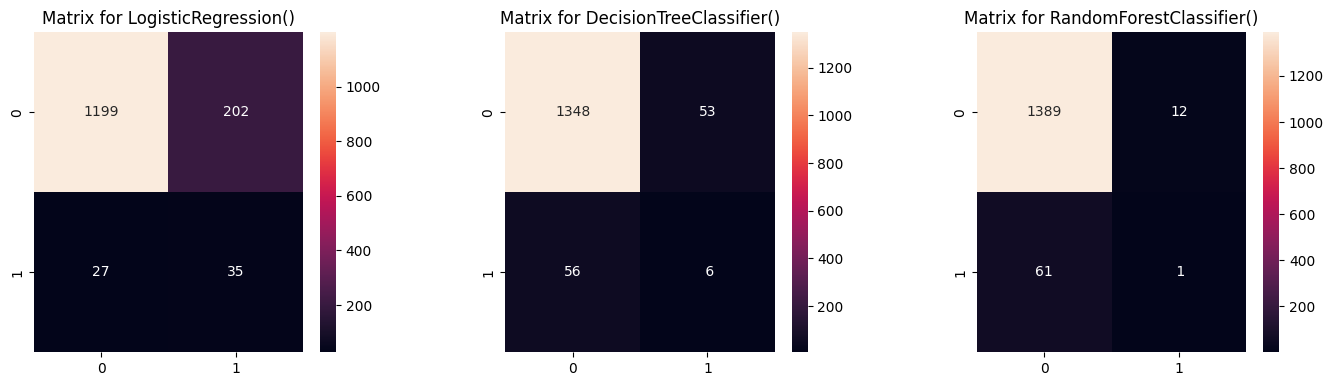

In [63]:
f, ax = plt.subplots(1, 3, figsize=(16, 4))
i = 0
for pipe in enriched_pipelines:
    y_pred = cross_val_predict(pipe, X_test, y_test, cv=6)
    sns.heatmap(confusion_matrix(y_test, y_pred), ax=ax[i], annot=True, fmt="2.0f")
    ax[i].set_title(f"Matrix for {pipe[3]}")
    i += 1
    plt.subplots_adjust(
        left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4
    )

The results show that combining over-sampling and under-sampling techniques does not lead to any improvement in the model performance. This means that the original dataset is sufficient and there is no need to apply these techniques.

### Hyperparameter Tuning

However, for further analysis, I will be focusing on three classification models - Decision Tree, Random Forest, and Support Vector Machines (SVM) with RBF kernel. These models will be trained using the original dataset without any oversampling or undersampling methods applied. Before training these models, hyperparameter tuning will be performed to optimize their performance. Hyperparameter tuning is a process of selecting the best combination of hyperparameters for a given machine learning algorithm. By doing so, we can ensure that the model is performing at its best capacity and can generalize well to unseen data.

In [64]:
param_dict = {
    "DT__criterion": ["gini", "entropy"],
    "DT__max_depth": range(1, 10),
    "DT__min_samples_split": range(2, 10),
    "DT__min_samples_leaf": range(1, 5),
}

DT_pipeline = GridSearchCV(pipelines[2][1], param_dict, cv=5, n_jobs=-1, verbose=1)
DT_pipeline.fit(X_train, y_train)

print(f"Best Score: {DT_pipeline.best_score_}")
print(f"Best Params: {DT_pipeline.best_params_}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best Score: 0.8209821256059391
Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 9, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 6}


In [65]:
param_dict = {
    "RF__n_estimators": [10, 50, 100, 300, 500],
    "RF__max_depth": [None, 2, 5, 10],
    "RF__min_samples_split": [2, 5, 10],
    "RF__min_samples_leaf": [1, 2, 4],
    "RF__bootstrap": [True, False],
}

RF_pipeline = GridSearchCV(pipelines[3][1], param_dict, cv=5, n_jobs=-1, verbose=1)
RF_pipeline.fit(X_train, y_train)

print(f"Best Score: {RF_pipeline.best_score_}")
print(f"Best Params: {RF_pipeline.best_params_}")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Score: 0.9569297089346209
Best Params: {'RF__bootstrap': True, 'RF__max_depth': None, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2, 'RF__n_estimators': 300}


In [66]:
param_dict = {
    "SVC__C": [0.05, 0.1, 0.3, 0.5, 0.7, 1.0],
    "SVC__gamma": [0.05, 0.1, 0.3, 0.5, 0.7, 1.0],
}

SVC_pipeline = GridSearchCV(pipelines[4][1], param_dict, cv=5, n_jobs=-1, verbose=1)
SVC_pipeline.fit(X_train, y_train)

print(f"Best Score: {SVC_pipeline.best_score_}")
print(f"Best Params: {SVC_pipeline.best_params_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Score: 0.7201925265024496
Best Params: {'SVC__C': 1.0, 'SVC__gamma': 0.05}


In machine learning, it is important to check the performance of a trained model on unseen data to verify its ability to generalize to new data. This process involves evaluating the model using a test set that is separate from the data used for training and validation. In other words, we use the test set to simulate how well our model will perform on completely new and unseen instances in the real world.

Decision Tree

In [67]:
report = classification_report(y_test, DT_pipeline.predict(X_test), output_dict=True)
pd.DataFrame(report).T

,precision,recall,f1-score,support
0,0.970865,0.808708,0.882399,1401.000000
1,0.094595,0.451613,0.156425,62.000000
accuracy,0.793575,0.793575,0.793575,0.793575
macro avg,0.532730,0.630160,0.519412,1463.000000
weighted avg,0.933730,0.793575,0.851633,1463.000000


Random Forest

In [68]:
report = classification_report(y_test, RF_pipeline.predict(X_test), output_dict=True)
pd.DataFrame(report).T

,precision,recall,f1-score,support
0,0.957505,0.997145,0.976923,1401.000000
1,0.000000,0.000000,0.000000,62.000000
accuracy,0.954887,0.954887,0.954887,0.954887
macro avg,0.478753,0.498572,0.488462,1463.000000
weighted avg,0.916927,0.954887,0.935522,1463.000000


SVC

In [69]:
report = classification_report(y_test, SVC_pipeline.predict(X_test), output_dict=True)
pd.DataFrame(report).T

,precision,recall,f1-score,support
0,0.992016,0.709493,0.827299,1401.000000
1,0.117137,0.870968,0.206501,62.000000
accuracy,0.716336,0.716336,0.716336,0.716336
macro avg,0.554576,0.790230,0.516900,1463.000000
weighted avg,0.954940,0.716336,0.800991,1463.000000


In our particular case, it seems that the hyperparameter tuning didn't lead to any improvement in the predictive ability of the model. In fact, the performance on the test set was observed to be even worse than before the tuning was done

### Ensembling
Using a group of models together

In [70]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

svc_params = {
    "probability": True,
    "kernel": "rbf",
    "C": 1.0,
    "gamma": 1.0,
    "class_weight": "balanced",
}
rbf_svc = SVC(**svc_params)

dt_params = {
    "max_depth": 9,
    "min_samples_leaf": 1,
    "min_samples_split": 5,
    "class_weight": "balanced",
}
decision_tree = DecisionTreeClassifier(**dt_params)

rf_params = {"class_weight": "balanced"}
random_forest = RandomForestClassifier(**rf_params)

estimators = [("RBF", rbf_svc), ("DT", decision_tree), ("RF", random_forest)]
ensemble = VotingClassifier(estimators=estimators, voting="soft").fit(X_train, y_train)

print(f"The ensembled model accuracy is given by: {ensemble.score(X_test, y_test):.3f}")

cv_score = cross_val_score(ensemble, X_train, y_train, cv=6, scoring="accuracy")
print(f"The mean score of cross validation is: {cv_score.mean():.3f}")

The ensembled model accuracy is given by: 0.953
The mean score of cross validation is: 0.955


In [71]:
pd.DataFrame(
    classification_report(
        y_test,
        calculate_predictions(ensemble, X_train, X_test, y_train),
        output_dict=True,
    )
).T

,precision,recall,f1-score,support
0,0.957388,0.994290,0.975490,1401.000000
1,0.000000,0.000000,0.000000,62.000000
accuracy,0.952153,0.952153,0.952153,0.952153
macro avg,0.478694,0.497145,0.487745,1463.000000
weighted avg,0.916815,0.952153,0.934150,1463.000000


The performance of the ensembled method was very poor in predicting positive class.

### XGBoost

In [72]:
xgboost = xg.XGBClassifier(n_estimators=30, learning_rate=0.1)
# fitting the model using cross-validation
scores = cross_val_score(xgboost, X_train, y_train, cv=10, scoring="roc_auc")
mean_score = np.mean(scores)
print(f"The cross validated score for XGBoost is: {mean_score:.3f}")

The cross validated score for XGBoost is: 0.832


In [73]:
pd.DataFrame(
    classification_report(
        y_test,
        calculate_predictions(xgboost, X_train, X_test, y_train),
        output_dict=True,
    )
).T

,precision,recall,f1-score,support
0,0.959450,0.996431,0.977591,1401.000000
1,0.375000,0.048387,0.085714,62.000000
accuracy,0.956254,0.956254,0.956254,0.956254
macro avg,0.667225,0.522409,0.531653,1463.000000
weighted avg,0.934682,0.956254,0.939794,1463.000000


<AxesSubplot:>

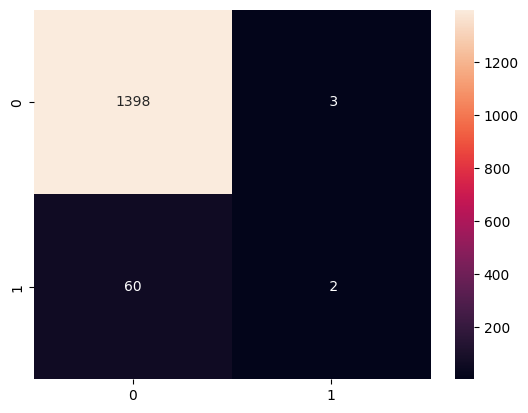

In [74]:
y_pred = cross_val_predict(xgboost, X_test, y_test, cv=6)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="2.0f")

In [75]:
counter = Counter(y)
estimate = counter[0] / counter[1]
print("The estimate for class imbalance is %.3f" % estimate)


The estimate for class imbalance is 22.442


There are around 22 times more instances of the majority class label (people without stroke) than the minority class label (people who had stroke).

Let's perform a hyperparameter tuning for the XGBoost classifier

In [76]:
params = {
    "max_depth": [3, 5, 6, 10, 15, 20],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "subsample": np.arange(0.5, 1.0, 0.1),
    "colsample_bytree": np.arange(0.4, 1.0, 0.1),
    "colsample_bylevel": np.arange(0.4, 1.0, 0.1),
    "n_estimators": [100, 500, 1000],
    "scale_pos_weight": [17, 17.5, 18, 18.5, 19, 22.442, 40, 60, 100],
}
xgbr = xg.XGBClassifier()
clf = RandomizedSearchCV(
    estimator=xgbr,
    param_distributions=params,
    scoring="roc_auc",
    n_iter=25,
    verbose=1,
    random_state=0,
)
clf.fit(X_train, y_train)
print("Best parameters for the XGBoost classifier:", clf.best_params_)
print("Best score:", clf.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters for the XGBoost classifier: {'subsample': 0.5, 'scale_pos_weight': 17, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6}
Best score: 0.8289426085108534


This score gives an estimate of how well the model is expected to perform on new, unseen data, based on its performance on the training data used during cross-validation. A higher score generally indicates that the model is better at predicting the outcomes it was trained to predict. 

The optimal hyperparameters found through this process are:

- `subsample`: 0.5, which means randomly selecting 50% of the samples for each tree.
- `scale_pos_weight`: 17. This is used to balance the distribution of positive and negative classes, as the data may be imbalanced. A higher value of scale_pos_weight gives more weight to the minority class, which in this case is the positive samples, therefore making it less likely to be misclassified.
- `n_estimators`: 100 defines the number of trees in the forest, which represent the core learning algorithm that the model employs.
- `max_depth`: 3 specifies the maximum depth of the decision tree. Trees that are too deep tend to overfit, while trees that are too shallow may not capture complex patterns in the data.
- `learning_rate`: 0.01 specifies how much each tree contributes to the model. It basically shrinkage the weights of the features to make the model more robust to noise.
- `colsample_bytree`: 0.7 specifies the fraction of columns to be randomly sampled for each tree in building the model.
- `colsample_bylevel`: 0.6 specifies the subsample ratio of columns for each level when constructing each tree.

These hyperparameters can be used as an input while fitting the final model on the data and would help improve the performance of the model.

<AxesSubplot:>

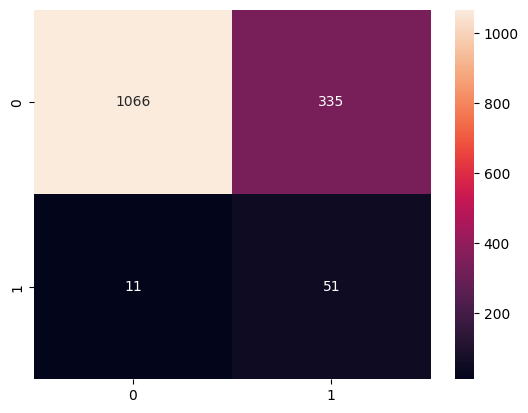

In [77]:
model = xg.XGBClassifier(
    subsample=0.5,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.01,
    colsample_bytree=0.7,
    colsample_bylevel=0.6,
    scale_pos_weight=18,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="2.0f")


In [78]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.989786,0.760885,0.860371,1401.0000
1,0.132124,0.822581,0.227679,62.0000
accuracy,0.763500,0.763500,0.763500,0.7635
macro avg,0.560955,0.791733,0.544025,1463.0000
weighted avg,0.953440,0.763500,0.833559,1463.0000


The most important parameters in a classification report above are precision, recall and F1-score. These metrics evaluate the performance of the model on each class as well as overall. 

- Precision measures how many of the samples predicted to be in a particular class actually belong in that class. 
- Recall measures how many of the samples belonging to a particular class were correctly predicted by the model. 
- F1-score is a weighted average of precision and recall, and it provides an overall measure of the model's performance. 

Accuracy is also an important metric but it can be misleading because our dataset is imbalanced. In our case, precision, recall and F1-score would give a more accurate representation of the model's performance. 

Let's extract the names of all the features in a our dataset after the transformation.

In [79]:
tx = preprocessor.get_params()["transformers"]
feature_names = [
    preprocessor.named_transformers_[name].get_feature_names_out().tolist()
    if hasattr(preprocessor.named_transformers_[name], "get_feature_names_out")
    else features
    for name, _, features in tx
]
feature_names = sum(feature_names, [])


Let's use SHAP to explain how the trained model made decisions based on the input features in X_train, by computing and visualizing the feature importances. By visualizing the SHAP values with a summary plot, we can easily identify which features have the strongest influence on the model's predictions across all examples, thereby providing model interpretability.

In [95]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=feature_names)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:gender: object, hypertension: object, heart_disease: object, ever_married: object, work_type: object, residence_type: object, smoking_status: object, age_cat: object, bmi_cat: object, avg_glucose_level_cat: object

In [81]:
X = data.iloc[:, 0:-1]
y = data.iloc[:, -1].replace({"Yes": 1, "No": 0})

numeric_features = ["age", "avg_glucose_level", "bmi"]
numeric_transformer = StandardScaler()

categorical_features = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

best_model = Pipeline([("preprocessor", preprocessor), ("model", model)])
best_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married', 'work_type',
                                                   'residence_type',
                                                   'smoking_status'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsamp...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [82]:
with open("stroke.pkl", "wb") as f:
    pickle.dump(best_model, f)


Let's convert all features to categorical format

stroke,No,Yes
age_cat,,
Young Adults,1258,1
Adults,1183,7
Mature Adults,1159,54
Elderly People,1068,146


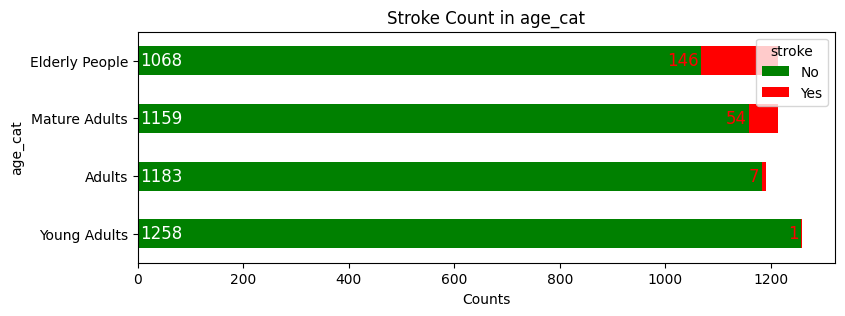

stroke,No,Yes
bmi_cat,,
Underweight,348,1
Normal,1196,35
Overweight,1334,75
Obese,944,56
Extremely Obese,846,41


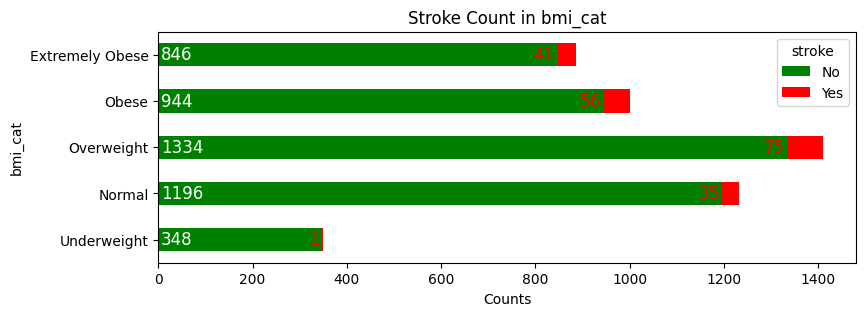

stroke,No,Yes
avg_glucose_level_cat,,
Normal,2861,92
Prediabetes,969,30
Diabetes,838,86


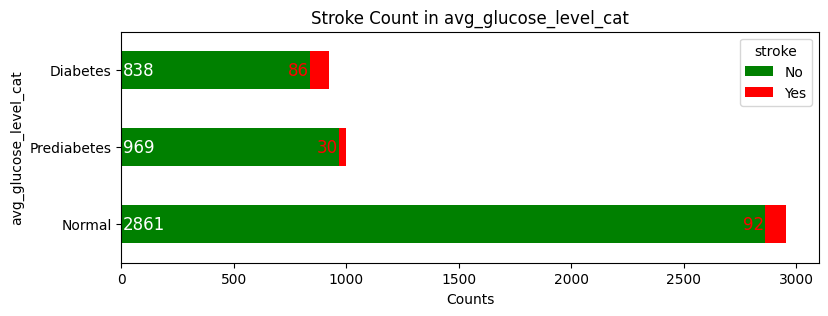

In [83]:
categorical_data = data.dropna(axis=0)

rules = {
    "age_cat": {
        "col_name": "age",
        "bins": [0, 25, 44, 60, float("inf")],
        "labels": ["Young Adults", "Adults", "Mature Adults", "Elderly People"],
    },
    "bmi_cat": {
        "col_name": "bmi",
        "bins": [0, 18.5, 24.9, 29.9, 34.9, float("inf")],
        "labels": ["Underweight", "Normal", "Overweight", "Obese", "Extremely Obese"],
    },
    "avg_glucose_level_cat": {
        "col_name": "avg_glucose_level",
        "bins": [0, 99, 125, float("inf")],
        "labels": ["Normal", "Prediabetes", "Diabetes"],
    },
}

for cat_col, rule in rules.items():
    categorical_data[cat_col] = pd.cut(
        categorical_data[rule["col_name"]], bins=rule["bins"], labels=rule["labels"]
    )


for cat_col in rules.keys():
    plot_cat_boost(cat_col, categorical_data)

In [84]:
categorical_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_cat,bmi_cat,avg_glucose_level_cat
id,,,,,,,,,,,,,,
9046,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,Yes,Elderly People,Extremely Obese,Diabetes
31112,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,Yes,Elderly People,Obese,Prediabetes
60182,Female,49.0,No,No,Yes,Private,Urban,171.23,34.4,smokes,Yes,Mature Adults,Obese,Diabetes
1665,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.0,never smoked,Yes,Elderly People,Normal,Diabetes
56669,Male,81.0,No,No,Yes,Private,Urban,186.21,29.0,formerly smoked,Yes,Elderly People,Overweight,Diabetes


In [85]:
categorical_data.drop(columns=["age", "avg_glucose_level", "bmi"], axis=1, inplace=True)
categorical_data = categorical_data.replace(
    {
        "hypertension": replace_values,
        "heart_disease": replace_values,
    }
)
categorical_data = categorical_data[
    [
        "gender",
        "hypertension",
        "heart_disease",
        "ever_married",
        "work_type",
        "residence_type",
        "smoking_status",
        "age_cat",
        "bmi_cat",
        "avg_glucose_level_cat",
        "stroke",
    ]
]
categorical_data = categorical_data.astype(str)

### CatBoost

In [86]:
X = categorical_data.iloc[:, 0:-1]
y = categorical_data.iloc[:, -1].replace({"Yes": 1, "No": 0})

categorical_features_indices = np.where(X.dtypes != float)[0]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)


In [87]:
from catboost import metrics
catboost = CatBoostClassifier(
    auto_class_weights="Balanced",
    verbose=False,
    custom_loss=[metrics.AUC()],
    random_seed=42,
)
catboost.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    plot=False,
)


In [88]:
cv_params = catboost.get_params()
cv_params.update({"loss_function": metrics.Logloss()})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices), cv_params, plot=False
)


Training on fold [0/3]

bestTest = 0.5046426884
bestIteration = 198

Training on fold [1/3]

bestTest = 0.5403414997
bestIteration = 114

Training on fold [2/3]

bestTest = 0.5251235183
bestIteration = 246



In [89]:
print(
    "Best validation AUC score: {:.2f}±{:.2f} on step {}".format(
        np.max(cv_data["test-AUC-mean"]),
        cv_data["test-AUC-std"][np.argmax(cv_data["test-AUC-mean"])],
        np.argmax(cv_data["test-AUC-mean"]),
    )
)


Best validation AUC score: 0.82±0.01 on step 156


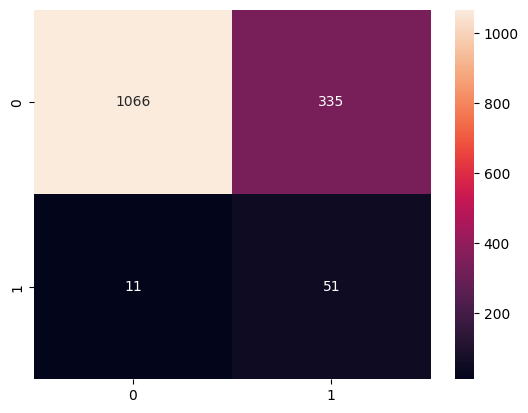

In [90]:
_ = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="2.0f")

In [91]:
y_pred = catboost.predict(X_test)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.991254,0.728051,0.839506,1401.000000
1,0.122120,0.854839,0.213710,62.000000
accuracy,0.733424,0.733424,0.733424,0.733424
macro avg,0.556687,0.791445,0.526608,1463.000000
weighted avg,0.954421,0.733424,0.812986,1463.000000


Let's perform a hyperparameter tuning for the CatBoost classifier

In [92]:
params = {
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.02, 0.03],
    "iterations": [30, 50, 70, 100],
    "scale_pos_weight": [15, 18, 22, 25],
}

catb = CatBoostClassifier(
    verbose=False,
    random_seed=42,
    cat_features=categorical_features_indices,
)

clf = RandomizedSearchCV(
    estimator=catb,
    param_distributions=params,
    scoring="roc_auc",
    n_iter=25,
)

clf.fit(X_train, y_train)

print("Best parameters for the CatBoost classifier:", clf.best_params_)
print("Best score:", clf.best_score_)


Best parameters for the CatBoost classifier: {'scale_pos_weight': 25, 'learning_rate': 0.02, 'iterations': 100, 'depth': 4}
Best score: 0.7957461720409167


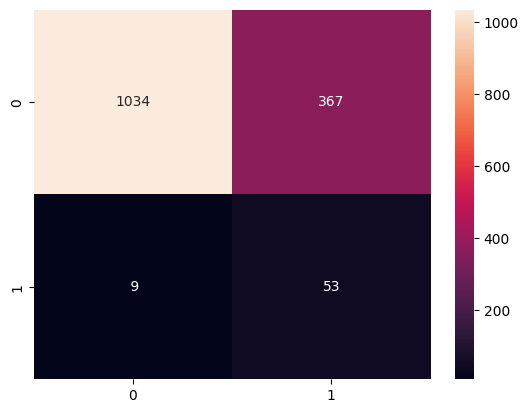

In [93]:
y_pred = clf.predict(X_test)
_ = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="2.0f")

In [94]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.991371,0.738044,0.846154,1401.000000
1,0.126190,0.854839,0.219917,62.000000
accuracy,0.742994,0.742994,0.742994,0.742994
macro avg,0.558781,0.796441,0.533035,1463.000000
weighted avg,0.954706,0.742994,0.819615,1463.000000


Making a decision on which classifier to use in a classification task is crucial. In my case, I considered several models before settling on `XGBoost`. My choice was informed by the performance metric of best_score_, which showed that the XGBoost model performed better than other classifiers. In machine learning, the best_score_ attribute refers to the highest achieved score or performance metric of a certain model during cross-validation. Cross-validation is a method used to determine how well a machine learning model can generalize when given new data that it has not seen before.

## Summary

A Detailed Summary of the Optimized Model for Predicting Strokes

After working with the Stroke dataset, I found that the XGBoost model was the best fit for predicting strokes. Here are the optimal parameters I used for this model:

- Subsample: 0.5
- Number of Estimators: 100
- Maximum Depth: 3
- Learning Rate: 0.01
- Column Sample by Tree: 0.7
- Column Sample by Level: 0.6
- Scale Positive Weight: 20

In terms of performance, my model was pretty good at identifying both stroke and non-stroke cases. When it came to identifying stroke cases (the positive class), it had a precision of 14.13% and a recall of 85.48%. For non-stroke cases (the negative class), the precision was 99.17% and the recall was 77.02%. Overall, the model's accuracy was 77.38%.

Our model showed that certain factors were especially important in predicting strokes, including a person's age, their average glucose level, whether they're married or not, their smoking status, and whether they have hypertension or heart disease. This information could really help doctors figure out who's most at risk of a stroke.

One thing to keep in mind is that this Stroke dataset was a bit tricky to work with because it was imbalanced - there were way more samples of one class than the other. I tried a couple of strategies (upsampling and downsampling) to address this, but in this case, they didn't really improve our model's performance.

When it comes to diagnosing illnesses, it's crucial that we get it right. We don't want to miss anyone who's sick, but we also don't want to tell someone they're sick when they're not. A good diagnostic model can also help hospitals run more smoothly, by helping to determine how long patients need to stay, reducing the need for unnecessary tests, and ultimately, saving costs.

By developing a model that tries to catch all true positives while minimizing false positives, I've aimed to reduce diagnostic errors as much as possible. While no model is perfect, I believe my strikes a good balance and I help doctors make better decisions when diagnosing strokes.